We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from deepxde.backend import tf
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



Defining the geometry of the powderbed:

In [2]:
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x_max = 1.54e-3
y_max = 0.23e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

Set the default float type to float64


Defining the time and the domian:

In [3]:
t_max = 0.002

time = dde.geometry.TimeDomain(0.0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [4]:
A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

defining the pde system:

In [5]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    molten = T > 1693
    
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_eff = tf.where(molten, k, 0.6*k)
    rho_eff = tf.where(molten, rho, 0.6*rho)
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [6]:
def top_bc(X, Y):
    
    molten = Y > 1693
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff =  k_eff = tf.where(molten, k, 0.6*k)
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff

ic = dde.icbc.IC(domain, lambda on_initial: 20.0 + T_0, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: on_boundary and np.isclose(x[2], z_max, atol=z_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : 20.0 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z_max, atol=z_max/20))

creating the dataset:

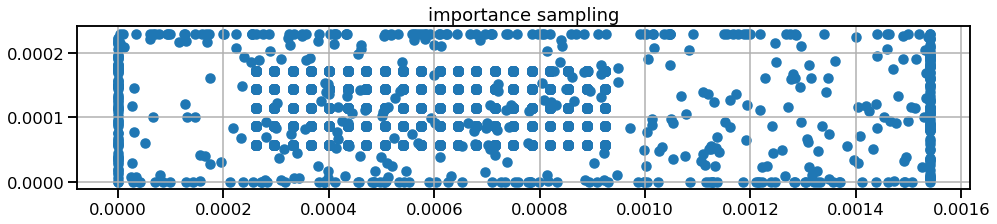

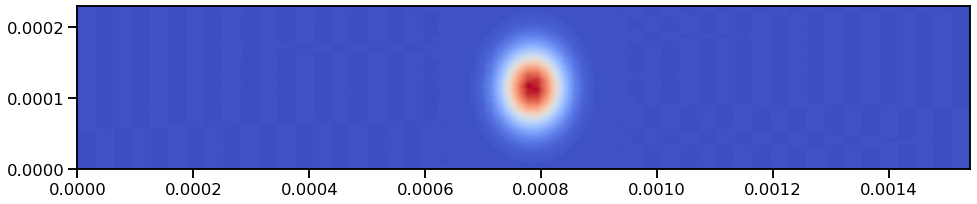

In [7]:
#setting training points at the important part of the boundary
x_lin = np.linspace(0.17*x_max, 0.6*x_max, 20)
y_lin = np.linspace(0.25*y_max, 0.75*y_max, 5)
z_lin = np.linspace(0.5*z_max, z_max, 10)
t_lin = np.linspace(0, t_max, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, z_lin, t_lin)
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top, sides],
                       num_domain = 100,
                       num_initial = 0,
                       num_boundary = 500,
                       train_distribution="pseudo",
                       anchors=X)

points = data.train_points().T
    
plt.figure(figsize = (16, 3))
plt.scatter(points[0], points[1])
#plt.colorbar()
plt.title('importance sampling')
plt.grid()

def top_bc_test(X):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
plot_data = griddata((np.ravel(xx), np.ravel(yy)), top_bc_test(X)[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, plot_data, 100, cmap=plt.cm.coolwarm)
#plt.colorbar()

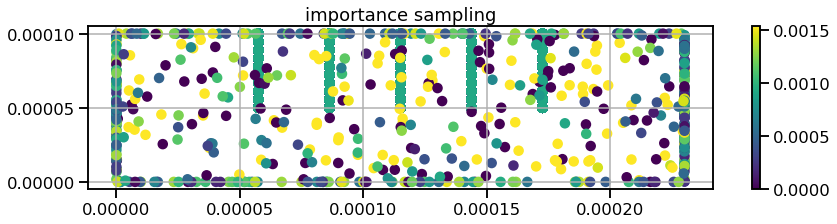

In [8]:
plt.figure(figsize = (14, 3))
plt.scatter(points[1], points[2], c = points[0])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

In [9]:
#net = dde.nn.FNN([4] + [50] * 8 + [1], "sin", "Glorot normal")
net = dde.nn.MsFFN([4] + [200] * 2 + [1], "sin", "Glorot normal", sigmas = [1, 0.1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x_max, 
         X[:, 1:2]/y_max,
         X[:, 2:3]/z_max,
         X[:, 3:4]/t_max], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = 20.0 + T_0 + Temperature*2000e1*t#*t*x*y*z#*(x - x_max)*(y-y_max) + 20.0 + T_0
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-07-01 18:15:18.177669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 18:15:18.283341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 18:15:18.283691: I tensorflow/stream_execu

'compile' took 4.100137 s



In [10]:
losshistory, train_state = model.train(epochs=0, display_every=1000)
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1, 1])
resampler = dde.callbacks.PDEResidualResampler(100)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.17e+08, 3.81e+15, 1.15e+03]    [4.17e+08, 3.81e+15, 1.15e+03]    []  

Best model at step 0:
  train loss: 3.81e+15
  test loss: 3.81e+15
  test metric: []

'train' took 2.199859 s



In [11]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e4, 1e3])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler])

Compiling model...
'compile' took 1.643891 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.25e-01, 9.88e+03, 1.61e+02]    [5.25e-01, 9.88e+03, 1.61e+02]    []  
100       [2.14e+02, 2.94e+03, 9.15e+01]                                          
200       [1.60e+02, 2.10e+03, 4.16e+01]                                          
300       [1.50e+02, 1.79e+03, 2.99e+01]                                          
400       [1.32e+02, 1.62e+03, 1.85e+01]                                          
500       [1.22e+02, 1.53e+03, 1.60e+01]                                          
600       [1.14e+02, 1.46e+03, 1.54e+01]                                          
700       [1.15e+02, 1.42e+03, 1.51e+01]                                          
800       [1.09e+02, 1.38e+03, 1.12e+01]                                          
900       [1.07e+02, 1.34e+03, 1.01e+01]                                

In [16]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e5, 1e3])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler])

Compiling model...
'compile' took 1.509043 s

Training model...

Step      Train loss                        Test loss                         Test metric
2507      [3.76e+01, 1.13e+04, 4.49e+00]    [3.76e+01, 1.13e+04, 4.49e+00]    []  
2600      [1.06e+02, 1.11e+04, 8.54e+00]                                          
2700      [2.03e+02, 1.09e+04, 1.62e+01]                                          
2800      [2.79e+02, 1.05e+04, 2.99e+01]                                          
2900      [2.17e+02, 1.03e+04, 2.97e+01]                                          
3000      [1.54e+02, 1.01e+04, 2.09e+01]                                          
3100      [1.25e+02, 1.01e+04, 1.72e+01]                                          
3200      [1.22e+02, 1.01e+04, 1.72e+01]                                          
3300      [1.18e+02, 1.01e+04, 1.58e+01]                                          
3400      [1.06e+02, 1.01e+04, 1.38e+01]                                          
INFO:tensorflow

In [44]:
model.save('okay/')

INFO:tensorflow:okay/-25791.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'okay/-25791.ckpt'

In [ ]:
model.restore('phase/-2271.ckpt')

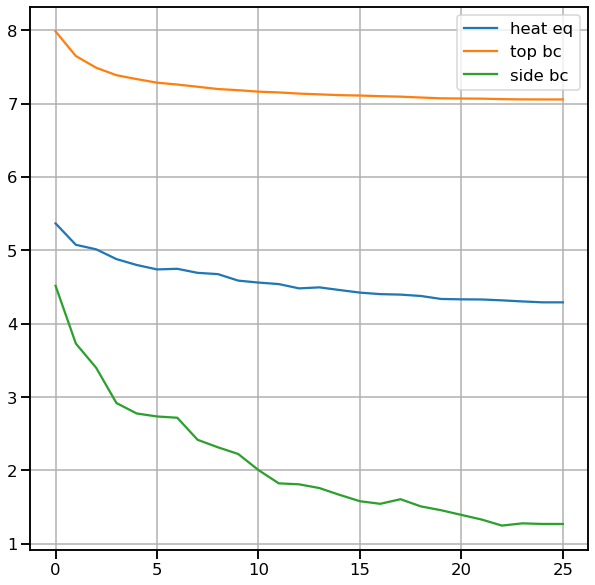

In [12]:
loss_names = ['heat eq', 'top bc', 'side bc', 'initial condition']
n = 2
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(np.log(loss[n:]), label = name)

plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


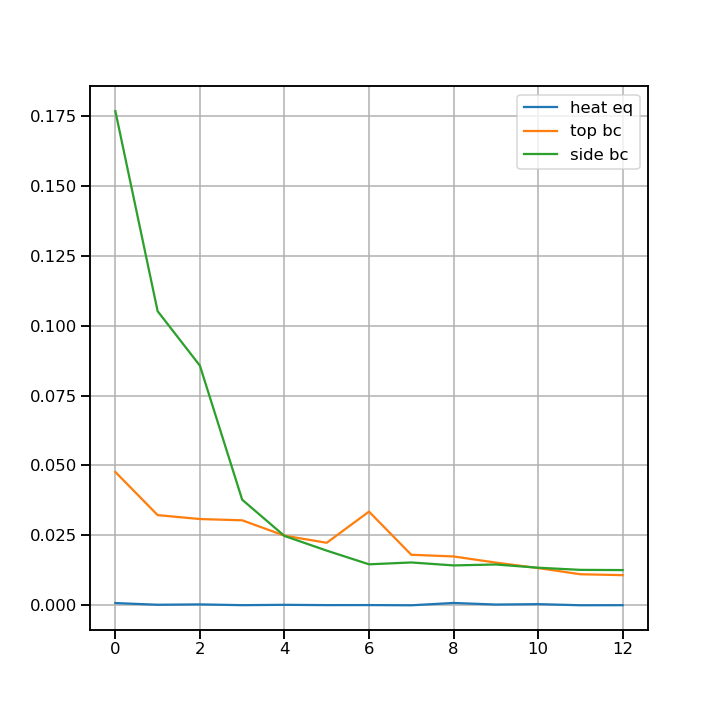

In [16]:
loss_names = ['heat eq', 'top bc', 'side bc', 'initial condition']
n = 13
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


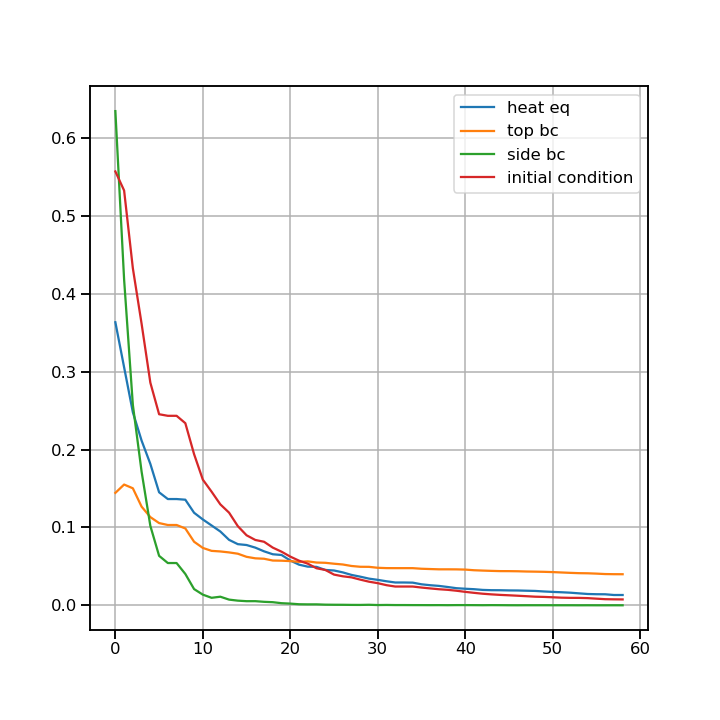

In [59]:
loss_names = ['heat eq', 'top bc', 'side bc', 'initial condition']
n = 62
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

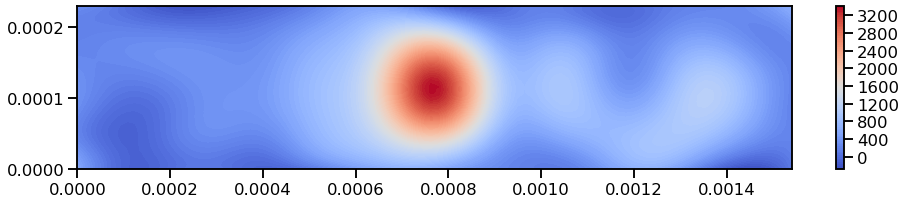

In [13]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

<IPython.core.display.Javascript object>


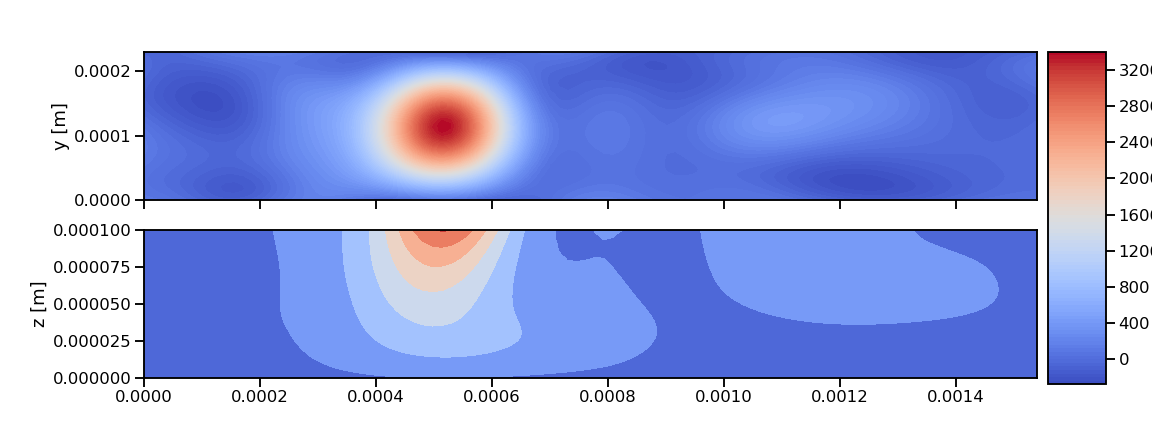

In [14]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (16, 6), sharex=True)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
z_lin = np.linspace(0, z_max)

xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y [m]')
#plt.colorbar(CS, ax = ax1)

xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
Y2 = model.predict(X2)

xi2 = np.linspace(xx2.min(), xx2.max(), 100)
zi2 = np.linspace(zz2.min(), zz2.max(), 100)
data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

CS2 = ax2.contourf(xi2, zi2, data2, 100, cmap=plt.cm.coolwarm)
ax2.set_ylabel('z [m]')
#plt.colorbar(CS2, ax = ax2)

cbar_ax = fig.add_axes([0.91, 0.11, 0.05, 0.77])
fig.colorbar(CS, cax=cbar_ax)

def animate(i):

    xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [i/100*t_max])
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
    Y = model.predict(X)

    xi = np.linspace(xx.min(), xx.max(), 100)
    yi = np.linspace(yy.min(), yy.max(), 100)
    data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

    CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
    
    xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [i/100*t_max])
    X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
    Y2 = model.predict(X2)

    xi2 = np.linspace(xx2.min(), xx2.max(), 100)
    zi2 = np.linspace(zz2.min(), zz2.max(), 100)
    data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

    CS2 = ax2.contourf(xi2, zi2, data2, intervall = 100, cmap=plt.cm.coolwarm)
            
FuncAnimation(fig, animate, frames = 100, interval=100)

In [ ]:
slice_data = np.genfromtxt('of_phase/slice1/slice_124.csv', delimiter = ',',skip_header = True)

x = slice_data[:,0]
y = slice_data[:,1]
z = slice_data[:,2]
T = slice_data[:,3]

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

def animate(i):
    
    slice_data = np.genfromtxt('of_phase/slice1/slice_{}.csv'.format(i), delimiter = ',',skip_header = True)
    T = slice_data[:,3]
    
    #xx, yy, zz, tt = np.meshgrid(x, y, [z.max], [(i+1)/125*t_max])
    X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max/125*(i+1))).T
    Y = model.predict(X)
    
    Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
    T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
    im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
    CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
            
anim = FuncAnimation(fig, animate, frames = 125, interval = 300)
from matplotlib.animation import FFMpegWriter

writervideo = FFMpegWriter(fps=60)
anim.save('pictures/video.mp4', writer=writervideo)

In [ ]:
x

In [ ]:
T.max()

In [ ]:
data.min()

In [ ]:
ref_data = np.genfromtxt('of_phase/csvs/data_124.csv', delimiter = ',',skip_header = True)

In [ ]:
ref_data.shape

In [ ]:
X = ref_data[:,0:3].T
t_value = np.ones(len(X[0]))*t_max
X = np.vstack((X, t_value)).T

In [ ]:
Y = model.predict(X)

In [ ]:
Y.max()

In [ ]:
diff = np.abs(Y.T[0] - ref_data[:,3:4].T)

In [ ]:
diff.mean()

In [ ]:
np.sqrt(diff.var())

In [ ]:
diff.max()

In [ ]:
diff.min()

In [ ]:
%matplotlib inline
plt.hist(diff[0], bins = 200, density=True)

In [ ]:
diff[0].shape

In [ ]:
np.heaviside(1700-1693, 1)

In [ ]:
tf.numpy_function(np.heaviside, T-1693, 1)

<IPython.core.display.Javascript object>


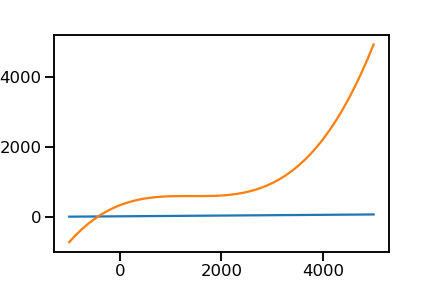

In [28]:
x = np.linspace(-1000, 5000)
plt.plot(x, (11.82+1.06e-2*x))

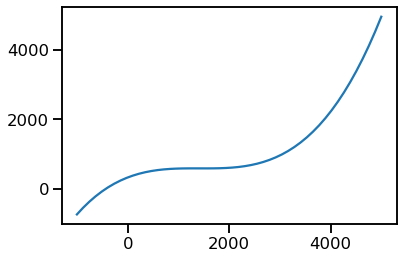

In [30]:
%matplotlib inline
x = np.linspace(-1000, 5000)
plt.plot(x, (330.9+0.563*x-4.015e-4*x**2+9.465e-8*x**3))